# Goalball LSTM – Data Preparation Pipeline
This notebook loads the three *_Throws_lstm_training.csv* files, normalises
coordinates by the matching video width × height, engineers features, and
outputs NaN-free tensors ready for the LSTM model.


## Import data


In [1]:
import pandas as pd, numpy as np, cv2, subprocess, json
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import glob

DATA_ROOT = Path(r"C:\Users\USER\Desktop\Thesis")   


# games = ["ISR_-_CAN_5-1", "TUR_-_BRA_3-1", "ISR_-_BRA_8-4"]
games = ["ISR_-_CAN_5-1", "TUR_-_BRA_3-1", "TUR_-_ISR_5-4", "ISR_-_BRA_8-4","CHI_-_TUR_7-5", "BRA_-_TUR_3-3"]

train_csvs = [
    DATA_ROOT / games[3] / "outputs" / f"{games[3]}_Throws_lstm_training.csv",
    DATA_ROOT / games[1] / "outputs" / f"{games[1]}_Throws_lstm_training.csv",
    DATA_ROOT / games[2] / "outputs" / f"{games[2]}_Throws_lstm_training.csv",
    DATA_ROOT / games[5] / "outputs" / f"{games[5]}_Throws_lstm_training.csv",
    DATA_ROOT / games[0] / "outputs" / f"{games[0]}_Throws_lstm_training.csv",
]
test_csv   = DATA_ROOT / games[4] / "outputs" / f"{games[4]}_Throws_lstm_training.csv"

# Load extra goal files and append to train_csvs
extra_goal_files = glob.glob(r"C:\Users\USER\Desktop\Thesis\Goals_Paralympics\outputs\*.csv")

extra_goal_paths = [Path(f) for f in extra_goal_files]
print(f"Found {len(extra_goal_paths)} extra goal files.")
train_csvs.extend(extra_goal_paths)


print(f"Train set: {train_csvs}")
print(f"Test set: {test_csv}")




Found 12 extra goal files.
Train set: [WindowsPath('C:/Users/USER/Desktop/Thesis/ISR_-_BRA_8-4/outputs/ISR_-_BRA_8-4_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/TUR_-_BRA_3-1/outputs/TUR_-_BRA_3-1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/TUR_-_ISR_5-4/outputs/TUR_-_ISR_5-4_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/BRA_-_TUR_3-3/outputs/BRA_-_TUR_3-3_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/ISR_-_CAN_5-1/outputs/ISR_-_CAN_5-1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_Paralympics24_Canada1_Japan2_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_Paralympics24_China3_Brazil1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_Paralympics24_Final_Israel3_Turkey8_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desk

## Data Pre-proccessing

 Helper ① · Find matching video (.mp4 / .mov)

In [2]:
def find_video_for_csv(csv_path: Path) -> Path | None:
    """Return the first .mp4 or .mov file whose stem starts with the game name."""
    game_dir = csv_path.parent.parent               # …/GAME
    prefix   = game_dir.name                        # e.g. 'ISR_-_CAN_5-1'
    vids = list(game_dir.glob(f"{prefix}*.mp4")) + list(game_dir.glob(f"{prefix}*.mov"))
    return vids[0] if vids else None

 Helper ② · Get video resolution

In [3]:
def get_video_dims(video_path: Path, fallback=(1920, 1080)):
    """Return (W,H). 1) try OpenCV; 2) try ffprobe; 3) fallback."""
    cap = cv2.VideoCapture(str(video_path))
    w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    if w and h:
        return w, h
    # ffprobe—catches ProRes .mov etc.
    try:
        out = subprocess.check_output(
            ["ffprobe", "-v", "error", "-select_streams", "v:0",
             "-show_entries", "stream=width,height", "-of", "json", str(video_path)],
            stderr=subprocess.STDOUT
        )
        meta = json.loads(out)
        return meta["streams"][0]["width"], meta["streams"][0]["height"]
    except Exception:
        return fallback


Build (csv ➜ (W,H)) mapping

In [4]:
dims = {}    # csv Path  ->  (W, H)

for csv in train_csvs + [test_csv]:
    vid = find_video_for_csv(csv)
    dims[csv] = get_video_dims(vid) if vid else (1920, 1080)
    print(csv.name, "↔", vid.name if vid else "<no video>", ":", dims[csv])


ISR_-_BRA_8-4_Throws_lstm_training.csv ↔ ISR_-_BRA_8-4.mov : (1920, 1080)
TUR_-_BRA_3-1_Throws_lstm_training.csv ↔ <no video> : (1920, 1080)
TUR_-_ISR_5-4_Throws_lstm_training.csv ↔ TUR_-_ISR_5-4.mov : (1920, 1080)
BRA_-_TUR_3-3_Throws_lstm_training.csv ↔ BRA_-_TUR_3-3.mov : (1920, 1080)
ISR_-_CAN_5-1_Throws_lstm_training.csv ↔ ISR_-_CAN_5-1.mov : (1920, 1080)
GOALS_Paralympics24_Canada1_Japan2_Throws_lstm_training.csv ↔ GOALS_Paralympics24_Canada1_Japan2.mp4 : (1774, 1504)
GOALS_Paralympics24_China3_Brazil1_Throws_lstm_training.csv ↔ GOALS_Paralympics24_Canada1_Japan2.mp4 : (1774, 1504)
GOALS_Paralympics24_Final_Israel3_Turkey8_Throws_lstm_training.csv ↔ GOALS_Paralympics24_Canada1_Japan2.mp4 : (1774, 1504)
GOALS_Paralympics24_Israel1_China6_Throws_lstm_training.csv ↔ GOALS_Paralympics24_Canada1_Japan2.mp4 : (1774, 1504)
GOALS_Paralympics24_Israel5_Canada1_Throws_lstm_training.csv ↔ GOALS_Paralympics24_Canada1_Japan2.mp4 : (1774, 1504)
GOALS_Paralympics24_Israel8_Brazil4_Throws_lstm_t

Helper ③ · clean_throw() (one segment)

After these operations the DataFrame g contains only dense numeric features (plus the new mask), perfectly ordered for sequence packing, and ready to be merged back into the full game table.

In [5]:
BALL_COLS = ["ball_x","ball_y","ball_w","ball_h","ball_conf"]
THROWER_COLS  = ["thrower_x","thrower_y","thrower_w","thrower_h","thrower_conf"]
DEFENDER_COLS = ["defender_x","defender_y","defender_w","defender_h","defender_conf"]

def clean_throw(g: pd.DataFrame, W: float, H: float) -> pd.DataFrame:
    # 1 ─ guarantee outcome token. 
    # Guarantees every throw has a legal (outcome, label) pair → later mapping to the six-class target never fails.
    g.loc[g["label"] == 0, "outcome"] = g.loc[g["label"] == 0, "outcome"].fillna("o")
    
    # 2 ─ chronological order
    # Orders the frames chronologically and then re-indexes them from 0…n-1. 
    # The LSTM’s sense of time comes only from row order; sorting eliminates annotation out-of-order glitches
    g = g.sort_values("frame").reset_index(drop=True)

    # 3 ─ detection mask + NaN fill
    # Adds a mask: 1 if the ball was actually detected this frame, 0 otherwise. 
    # Lets the model learn when coordinates are trustworthy vs. forward-filled guesses.
    g["ball_seen"] = (~g["ball_conf"].isna()).astype(int) 
    g["thrower_seen"]  = (~g["thrower_conf"].isna()).astype(int)
    g["defender_seen"] = (~g["defender_conf"].isna()).astype(int)

    # Forward-fill, then back-fill every NaN in the five ball geometry columns within the throw.
    # Creates a continuous trajectory even if a detector missed a few frames.
    for cols in (BALL_COLS, THROWER_COLS, DEFENDER_COLS):
        g[cols] = g[cols].ffill().bfill()

    # 4 ─ coordinate normalisation\
    # Converts absolute pixels to unit-square [0,1] values.
    # Makes the model resolution-agnostic (works on 1080 p and 720 p).
    for actor in ("ball", "thrower", "defender"):
        g[f"{actor}_x"] /= W
        g[f"{actor}_w"] /= W
        g[f"{actor}_y"] /= H
        g[f"{actor}_h"] /= H
    
    # 5 ─ time cues & velocity
    # Adds a relative-time feature: 0 at first frame, 1 at last.
    # Gives the LSTM an explicit notion of “early vs. late” in the throw.
    g["rel_t"] = g.index / (len(g) - 1) if len(g) > 1 else 0.0

    #Stores the difference in original frame numbers (can be >1 if frames were skipped).
    #Signals irregular sampling / detector dropouts. e.g: Frames 901, 902, 907 → gaps 0, 1, 5.
    g["gap"]   = g["frame"].diff().fillna(0)

    # First-order difference of normalised ball_x, ball_y → velocity per frame.
    # Motion often distinguishes outs (fast, wide) vs. blocks/goals (slows near defenders).
    # If ball_x goes 0.70 → 0.75 → 0.81 the ball_dx are 0, 0.05, 0.06.
    g[["ball_dx","ball_dy"]] = g[["ball_x","ball_y"]].diff().fillna(0)
    
    # 6 ─ binary encode segment_type
    # Encodes the string from/to as 0/1.
    # Cheap categorical info: “wind-up” vs. “release” phase of the throw.
    # 'from' → 0 ; 'to' → 1.
    g["segment_type"] = (g["segment_type"] == "to").astype(int)
    return g


Helper ④ · preprocess_full() (whole game)

In [6]:
CLS = {('o',1):0, ('o',0):1, ('g',1):2, ('g',0):3, ('b',1):4, ('b',0):5}

def preprocess_full(df_raw: pd.DataFrame, W: float, H: float,  uid_col: str = "throw_uid") -> pd.DataFrame:
    # A. apply clean_throw per segment
    df = (df_raw
          .groupby(uid_col, group_keys=False)
          .apply(clean_throw, W=W, H=H)
          .reset_index(drop=True))
    # B. add six-class target
    def add_class(g):
        # ── find the first non-null outcome inside the group ──
        non_null = g["outcome"].dropna()
        outcome  = non_null.iloc[0] if len(non_null) else "o"   # fallback
        
        label    = int(g["label"].iloc[0])   # 0 = false, 1 = real/valid
        g["class_id"] = CLS[(outcome, label)]
        return g

    df = df.groupby("throw_uid", group_keys=False).apply(add_class)
    # C. drop leaks / sparse cols
    drop_cols = ["frame","label","outcome"] 
    return df.drop(columns=drop_cols)


Run pre-processing on all CSV files

In [7]:
# helper to load → clean one csv

def load_and_clean(csv_path: Path):
    raw       = pd.read_csv(csv_path)

    # ── use the file’s own tag so every game has a private namespace ──
    game_tag  = csv_path.stem.split("_Throws")[0]        # e.g. GOALS_Paralympics24_Turkey5_Israel4
    raw["segment_uid"] = raw["segment_id"].astype(str).radd(f"{game_tag}_")

    raw["throw_uid"]   = (raw["segment_id"] + 1)//2
    raw["throw_uid"]   = raw["throw_uid"].astype(str).radd(f"{game_tag}_")

    W, H = dims[csv_path]          # keeps working as before
    return preprocess_full(raw, W, H, uid_col="throw_uid")

df_train_clean = pd.concat([load_and_clean(p) for p in train_csvs],
                           ignore_index=True)
df_test_clean  = load_and_clean(test_csv)

print("train clean:", df_train_clean.shape, " test clean:", df_test_clean.shape)
print(f"-----------distinct throw_uids in train: {df_train_clean['throw_uid'].nunique()}----------------")
print(df_train_clean.head(3))

C:\Users\USER\AppData\Local\Temp\ipykernel_19636\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df_raw
C:\Users\USER\AppData\Local\Temp\ipykernel_19636\2054764792.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("throw_uid", group_keys=False).apply(add_class)
C:\Users\USER\AppData\Local\Temp\ipykernel_19636\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply

train clean: (131506, 27)  test clean: (23874, 27)
-----------distinct throw_uids in train: 1175----------------
   segment_id  segment_type    ball_x    ball_y    ball_w    ball_h  \
0           1             0  0.309021  0.436945  0.019773  0.033826   
1           1             0  0.305917  0.435325  0.019106  0.033519   
2           1             0  0.304375  0.423746  0.016054  0.030574   

   ball_conf  thrower_x  thrower_y  thrower_w  ...      segment_uid  \
0   0.869101   0.318821   0.448167   0.046224  ...  ISR_-_BRA_8-4_1   
1   0.843102   0.315926   0.448966   0.046655  ...  ISR_-_BRA_8-4_1   
2   0.859787   0.315074   0.448416   0.042821  ...  ISR_-_BRA_8-4_1   

         throw_uid  ball_seen  thrower_seen  defender_seen     rel_t  gap  \
0  ISR_-_BRA_8-4_1          1             1              0  0.000000  0.0   
1  ISR_-_BRA_8-4_1          1             1              0  0.010526  1.0   
2  ISR_-_BRA_8-4_1          1             1              0  0.021053  1.0   

    ball

C:\Users\USER\AppData\Local\Temp\ipykernel_19636\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df_raw
C:\Users\USER\AppData\Local\Temp\ipykernel_19636\2054764792.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("throw_uid", group_keys=False).apply(add_class)


In [8]:
df_train_clean.head(3)


,segment_id,segment_type,ball_x,ball_y,ball_w,ball_h,ball_conf,thrower_x,thrower_y,thrower_w,...,segment_uid,throw_uid,ball_seen,thrower_seen,defender_seen,rel_t,gap,ball_dx,ball_dy,class_id
0,1,0,0.309021,0.436945,0.019773,0.033826,0.869101,0.318821,0.448167,0.046224,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.000000,0.0,0.000000,0.000000,4
1,1,0,0.305917,0.435325,0.019106,0.033519,0.843102,0.315926,0.448966,0.046655,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.010526,1.0,-0.003104,-0.001620,4
2,1,0,0.304375,0.423746,0.016054,0.030574,0.859787,0.315074,0.448416,0.042821,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.021053,1.0,-0.001543,-0.011579,4


Lightly reduce the majority-class (b1 = class_id 4) to 50 %

In [9]:
# import numpy as np
# import pandas as pd
# print("Rows  before down-sample :", len(df_train_clean))

# b1_mask  = df_train_clean["class_id"] == 4          # 4  = ('b',1)
# keep_b1  = df_train_clean[b1_mask].sample(frac=0.50, random_state=0)
# df_train_clean = pd.concat([df_train_clean[~b1_mask], keep_b1])

# print("Rows  after down-sample :", len(df_train_clean))
# print(df_train_clean["class_id"].value_counts().sort_index())

 Horizontal-flip data-augmentation 

 horizontal-mirror data-augmentation for class g1 (mirror flipping)


In [10]:
# –––  Data-augmentation: left↔right mirror for g1 throws –––
def mirror_throw(df_one):
    df_flip = df_one.copy()
    # 1) reflect X coordinates (normalised 0‒1)
    for col in ["ball_x", "thrower_x", "defender_x"]:
        df_flip[col] = 1.0 - df_flip[col]
    # 2) flip X velocities (dx); dy unchanged
    df_flip["ball_dx"] *= -1
    return df_flip

g1_id  = CLS[('g',1)]          # == 2
flip_df = (df_train_clean
           .loc[df_train_clean["class_id"] == g1_id]
           .groupby("throw_uid", group_keys=False)
           .apply(mirror_throw))

# new unique IDs so they don't collide at collate-time
flip_df["throw_uid"] = flip_df["throw_uid"].astype(str) + "_flip"

df_train_clean = pd.concat([df_train_clean, flip_df], ignore_index=True)
print("After mirroring:", df_train_clean['class_id'].value_counts().sort_index())



# multiple targets to flip                                        ---- uses augmentation to out aswell as goals.
# # class IDs you want to mirror
# targets_to_flip = [CLS[('g', 1)],   # g1  == 2
#                    CLS[('o', 1)]]   # o1  == 0

# flip_dfs = []
# for cid in targets_to_flip:
#     flip_part = (df_train_clean
#                  .loc[df_train_clean["class_id"] == cid]
#                  .groupby("throw_uid", group_keys=False)
#                  .apply(mirror_throw))

#     # make new unique IDs so they don’t collide at collate-time
#     flip_part["throw_uid"] = flip_part["throw_uid"].astype(str) + f"_flip{cid}"
#     flip_dfs.append(flip_part)

# # append all mirrored rows to the training frame
# df_train_clean = pd.concat([df_train_clean, *flip_dfs], ignore_index=True)

# print("After mirroring:", df_train_clean['class_id'].value_counts().sort_index())


After mirroring: class_id
0      8339
1      5652
2     27190
4    103920
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_19636\32287703.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mirror_throw))


Standard-scale every numeric feature

StandardScaler subtracts the training mean and divides by the
training standard deviation for each column, so every feature now
has roughly mean 0 and std 1. This helps the optimizer converge
faster and prevents any single feature (e.g. gap) from dominating
the gradient.

In [11]:
from sklearn.preprocessing import StandardScaler

FEATURE_COLS = [
    # timing & category
    "segment_type", "rel_t", "gap",
    # masks
    "defender_seen", "thrower_seen", "ball_seen",
    # ball    (7)
    "ball_x","ball_y","ball_dx","ball_dy","ball_w","ball_h","ball_conf",
    # thrower (5)
    "thrower_x","thrower_y","thrower_w","thrower_h","thrower_conf",
    # defender (5)
    "defender_x","defender_y","defender_w","defender_h","defender_conf",
]                               # 23 features total

# final safety pass: replace any leftover NaNs with 0
df_train_clean[FEATURE_COLS] = df_train_clean[FEATURE_COLS].fillna(0.0)
df_test_clean [FEATURE_COLS] = df_test_clean [FEATURE_COLS].fillna(0.0)

scaler = StandardScaler()
df_train_clean[FEATURE_COLS] = scaler.fit_transform(df_train_clean[FEATURE_COLS])
df_test_clean [FEATURE_COLS] = scaler.transform   (df_test_clean [FEATURE_COLS])


print("Scaling ✓  |  Train rows:", len(df_train_clean),
      " Test rows:", len(df_test_clean))
print("unique segment IDs train:", df_train_clean["throw_uid"].nunique())
print("unique segment IDs test :", df_test_clean ["throw_uid"].nunique())



Scaling ✓  |  Train rows: 145101  Test rows: 23874
unique segment IDs train: 1281
unique segment IDs test : 224


## Hand it to PyTorch


 Convert each throw to a sequence tensor

In [12]:
import numpy as np
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

def make_sequences(df):
    seqs, labels = [], []
    for _, g in df.groupby("throw_uid"):
        seqs.append(g[FEATURE_COLS].values.astype("float32"))   # shape (T, 23)
        labels.append(int(g["class_id"].iloc[0]))                # 0‒5
    return seqs, np.array(labels, dtype=np.int64)

train_seqs, train_labels = make_sequences(df_train_clean)
test_seqs,  test_labels  = make_sequences(df_test_clean)

# ── class-frequency weights (rare class ⇒ larger weight) ─────────────────
freq      = np.bincount(train_labels, minlength=6)
mask      = freq > 0                    # only classes that exist in training
class_w    = torch.zeros(6, device=device, dtype=torch.float32)


class_w[mask] = torch.sqrt(torch.tensor(1.0 / freq[mask],
                                        dtype=torch.float32,
                                        device=device))

class_w[2] *= 2  # boost the 'g1' class weight
# class_w[0] *= 0.5  # boost the 'o1' class weight
# class_w[1] *= 0.5


print("Per-class weights:", class_w.cpu().numpy())

# ── focal-loss function (γ = 2) ──────────────────────────────────────
γ = 2
def focal_loss(logits, y):
    ce = nn.functional.cross_entropy(
            logits, y, reduction='none', weight=class_w)
    pt = torch.softmax(logits, 1).gather(1, y[:, None]).squeeze()
    return ((1 - pt) ** γ * ce).mean()


print("Detects (From&To)  train / test :", len(train_seqs), "/", len(test_seqs))
print("Example tensor shape :", train_seqs[0].shape)


Per-class weights: [0.10910895 0.12803687 0.13736056 0.         0.03289758 0.        ]
Detects (From&To)  train / test : 1281 / 224
Example tensor shape : (107, 23)


In [13]:
print(class_w)

tensor([0.1091, 0.1280, 0.1374, 0.0000, 0.0329, 0.0000], device='cuda:0')


## LSTM Model Training

In [14]:
import torch, numpy as np
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import collections, torch, numpy as np

Dataset + collate fn

Turn each throw tensor + label into a PyTorch Dataset;
collate pads variable-length sequences so a whole batch fits in one tensor.

In [15]:
class ThrowDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, labels):
        self.seqs   = [torch.tensor(s) for s in seqs]
        self.labels = torch.tensor(labels)
    def __len__(self):  return len(self.seqs)
    def __getitem__(self, idx):  return self.seqs[idx], self.labels[idx]

def collate(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs])
    xs_pad  = pad_sequence(xs, batch_first=True)        # → [B, T_max, 23]
    return xs_pad, lengths, torch.tensor(ys)


Sequences → DataLoaders

Groups every throw_uid, builds (T × 23) tensors, then wraps them
in shuffled train-loader and ordered test-loader.

In [16]:
def make_sequences(df):
    seqs, labels = [], []
    for _, g in df.groupby("throw_uid"):        # merged ID (from+to)
        seqs.append(g[FEATURE_COLS].values.astype("float32"))
        labels.append(int(g["class_id"].iloc[0]))
    return seqs, np.array(labels, dtype=np.int64)

train_seqs, train_labels = make_sequences(df_train_clean)
test_seqs,  test_labels  = make_sequences(df_test_clean)



sample_w = torch.tensor([1.0 / freq[l] for l in train_labels],
                        dtype=torch.float32)

sampler = torch.utils.data.WeightedRandomSampler(
             weights      = sample_w,
             num_samples  = len(train_labels) * 3,   # 3× epoch
             replacement  = True)

train_loader = torch.utils.data.DataLoader(
    ThrowDataset(train_seqs, train_labels),
    batch_size=32,
    sampler=sampler,     
    collate_fn=collate
)



test_loader  = torch.utils.data.DataLoader(
    ThrowDataset(test_seqs,  test_labels),
    batch_size=32, shuffle=False, collate_fn=collate)

print("Sequences  train / test :", len(train_seqs), "/", len(test_seqs))


Sequences  train / test : 1281 / 224


Bi-directional LSTM

Two-layer Bi-LSTM reads the padded sequence; the concat of last forward &
backward hidden states feeds a small MLP head that outputs 6 logits.


In [17]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ThrowLSTM(nn.Module):
    def __init__(self, n_features=23, hidden=128, layers=2, n_classes=6):
        super().__init__()
        # 1) Bi-directional LSTM with inter-layer dropout
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        # 2) Attention scorer
        self.attn = nn.Sequential(
            nn.Linear(hidden * 2, 64),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        # 3) Final classification head
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, n_classes)
        )

    def forward(self, x, lengths):
        # x: (batch, seq_len, n_features)
        # lengths: 1D tensor or list with actual sequence lengths

        # Ensure lengths is a CPU int64 tensor for packing
        if not torch.is_tensor(lengths):
            lengths_cpu = torch.tensor(lengths, dtype=torch.int64)
        else:
            lengths_cpu = lengths.to(dtype=torch.int64, device='cpu')

        # 1) Pack padded sequence
        packed = pack_padded_sequence(
            x, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        # 2) Run through Bi-LSTM
        packed_out, _ = self.lstm(packed)
        # 3) Unpack back to (batch, seq_len, hidden*2)
        out_unpacked, _ = pad_packed_sequence(packed_out, batch_first=True)

        # 4) Build padding mask on the same device as out_unpacked
        B, L, _ = out_unpacked.size()
        idxs = torch.arange(L, device=out_unpacked.device) \
                    .unsqueeze(0).expand(B, L)
        lengths_dev = lengths_cpu.to(out_unpacked.device)
        mask = idxs >= lengths_dev.unsqueeze(1)  # BoolTensor (batch, seq_len)

        # 5) Compute raw attention scores and mask padding positions
        scores = self.attn(out_unpacked).squeeze(-1)          # (batch, seq_len)
        scores = scores.masked_fill(mask, float('-inf'))     # pad → -inf
        weights = torch.softmax(scores, dim=1)               # (batch, seq_len)

        # 6) Weighted sum of hidden states → context vector
        context = (out_unpacked * weights.unsqueeze(-1)).sum(dim=1)  # (batch, hidden*2)

        # 7) Final classification
        return self.head(context)


Training loop (20 epochs)

For each epoch we run one pass over train-loader (updates weights) and
one pass over test-loader (no grad).
Print accuracy and cross-entropy loss every epoch.

In [18]:
model  = ThrowLSTM(n_features=23, hidden=128, layers=2, n_classes=6).to(device)
print(F"NN {model}")

NN ThrowLSTM(
  (lstm): LSTM(23, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
  (head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [19]:
from datetime import datetime
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall
prec_metric = MulticlassPrecision(num_classes=6, average='none').to(device)
rec_metric  = MulticlassRecall(   num_classes=6, average='none').to(device)
f1_metric = MulticlassF1Score(num_classes=6, average='macro').to(device)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")   # e.g. "20250707_1423"
CKPT   = f"best_throw_lstm_{RUN_ID}.pt"              # unique filename

# ── 0 · model, loss, optimiser ───────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = ThrowLSTM(n_features=23, hidden=128, layers=2, n_classes=6).to(device)
print(F"NN {model}")

# focal_loss already captures your class_w & γ  ➜ just point to it
loss_fn = focal_loss

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
              opt, mode="max", factor=0.3, patience=3, verbose=True)

# ── 1 · helpers ──────────────────────────────────────────────────────
BEST_ACC = 0.0
PATIENCE = 10
BEST_F1 = 0.0
BEST_PREC_G1 = 0
BEST_REC_G1 = 0
cooldown = PATIENCE

# def run_epoch(loader, train=True):
#     model.train(train)
#     tot, correct, loss_sum = 0, 0, 0.0
#     for X, lengths, y in loader:
#         X, lengths, y = X.to(device), lengths.to(device), y.to(device)
#         if train:
#             opt.zero_grad()
#         logits = model(X, lengths)
#         loss   = loss_fn(logits, y)
#         if train:
#             loss.backward()
#             opt.step()
#         loss_sum += loss.item() * y.size(0)
#         correct  += (logits.argmax(1) == y).sum().item()
#         tot      += y.size(0)
#     return loss_sum / tot, correct / tot

# def run_epoch(loader, train=True):
#     model.train(train)
#     tot, correct, loss_sum = 0, 0, 0.0
#     f1_metric.reset()                        # NEW

#     for X, lengths, y in loader:
#         X, lengths, y = X.to(device), lengths.to(device), y.to(device)

#         if train:
#             opt.zero_grad()

#         logits = model(X, lengths)
#         loss   = loss_fn(logits, y)

#         if train:
#             loss.backward()
#             opt.step()

#         loss_sum += loss.item() * y.size(0)
#         pred      = logits.argmax(1)
#         f1_metric.update(pred, y)            # NEW

#         correct  += (pred == y).sum().item()
#         tot      += y.size(0)

#     f1 = f1_metric.compute().item()          # NEW
#     return loss_sum / tot, correct / tot, f1

def run_epoch(loader, train=True):   #FOCUSING ON MAXIMIZING PRESCISION / RECALL
    model.train(train)
    tot, correct, loss_sum = 0, 0, 0.0

    # reset per-class stats
    prec_metric.reset()
    rec_metric.reset()

    for X, lengths, y in loader:
        X, lengths, y = X.to(device), lengths.to(device), y.to(device)
        if train: opt.zero_grad()

        logits = model(X, lengths)
        loss   = loss_fn(logits, y)
        if train:
            loss.backward()
            opt.step()

        # accumulate
        loss_sum += loss.item() * y.size(0)
        pred      = logits.argmax(1)
        correct  += (pred == y).sum().item()
        tot      += y.size(0)

        # update per-class metrics
        prec_metric.update(pred, y)
        rec_metric.update(pred, y)

    # compute arrays of size [6]
    precs = prec_metric.compute()  # tensor([P_o1, P_o0, P_g1, P_g0, P_b1, P_b0])
    recs  = rec_metric.compute()

    # extract the g1 (goal) entry; it's index 2
    prec_g1 = precs[2].item()
    rec_g1  = recs[2].item()

    return loss_sum / tot, correct / tot, prec_g1, rec_g1


# ── 2 · main loop ────────────────────────────────────────────────────
for ep in range(1, 100):
    tr_loss, tr_acc, tr_prec_g1, tr_rec_g1 = run_epoch(train_loader, train=True)
    te_loss, te_acc, te_prec_g1, te_rec_g1 = run_epoch(test_loader,  train=False)
    lr_sched.step(te_acc)
    # lr_sched.step(te_f1)
    # lr_sched.step(te_rec_g1) # step by maximizing recall on g1

    lr_now = opt.param_groups[0]["lr"]
    print(f"{ep:03d} | lr {lr_now:.2e} | "
          f"train {tr_acc:.3f} | test {te_acc:.3f} | "
          f"loss {tr_loss:.4f}/{te_loss:.4f}")
    # print(f"{ep:03d} | lr {lr_now:.2e} | "
    #     f"train acc {tr_acc:.3f}  g1 rec {tr_rec_g1:.3f} | "
    #     f"test  acc {te_acc:.3f}  g1 rec {te_rec_g1:.3f} | "
    #     f"loss {tr_loss:.4f}/{te_loss:.4f}")

    # early-stop
    if te_acc > BEST_ACC + 1e-9:
    # if te_f1 > BEST_F1 + 1e-9:
    # if te_rec_g1 > BEST_REC_G1 + 1e-9:
    # if te_prec_g1 >= BEST_PREC_G1 + 1e-9:
        # BEST_PREC_G1 = te_prec_g1
        # BEST_REC_G1 = te_rec_g1
        BEST_ACC = te_acc
        # BEST_F1 = te_f1
        torch.save(model.state_dict(), CKPT)
        print(f"  🔖  New best — saved to {CKPT}")
        cooldown = PATIENCE
    else:
        cooldown -= 1
        if cooldown == 0:
            print(f"⏹  Early-stopped @ epoch {ep}  (best acc {BEST_ACC:.3f})")
            break

print("Best held-out accuracy:", BEST_ACC)
print("Final model saved as :", CKPT)


NN ThrowLSTM(
  (lstm): LSTM(23, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
  (head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


001 | lr 1.00e-03 | train 0.549 | test 0.210 | loss 0.0473/0.0273
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
002 | lr 1.00e-03 | train 0.764 | test 0.442 | loss 0.0163/0.0195
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
003 | lr 1.00e-03 | train 0.850 | test 0.527 | loss 0.0063/0.0176
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
004 | lr 1.00e-03 | train 0.881 | test 0.674 | loss 0.0069/0.0196
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
005 | lr 1.00e-03 | train 0.897 | test 0.817 | loss 0.0062/0.0208
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
006 | lr 1.00e-03 | train 0.927 | test 0.656 | loss 0.0043/0.0166
007 | lr 1.00e-03 | train 0.955 | test 0.808 | loss 0.0022/0.0216
008 | lr 1.00e-03 | train 0.966 | test 0.844 | loss 0.0016/0.0238
  🔖  New best — saved to best_throw_lstm_20250905_182750.pt
009 | lr 1.00e-03 | train 0.982 | test 0.893 | loss 0.0010/0.0295
  🔖  New best — saved to best_throw_lstm_20250

 Detailed test report
 (OverAll ROC Curve
1. Micro-average is dominated by large classes (abundant b1 samples).
It tells the model’s instance-level discrimination.)

              precision    recall  f1-score   support

          o1       0.61      0.82      0.70        17
          o0       1.00      0.50      0.67         2
          g1       1.00      0.55      0.71        11
          g0       0.00      0.00      0.00         0
          b1       0.95      0.95      0.95       194
          b0       0.00      0.00      0.00         0

    accuracy                           0.92       224
   macro avg       0.59      0.47      0.50       224
weighted avg       0.93      0.92      0.92       224



C:\Users\USER\AppData\Local\Temp\ipykernel_19636\4092268482.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT, map_location=device))

,Predicted:o1,Predicted:o0,Predicted:g1,Predicted:g0,Predicted:b1,Predicted:b0
True:o1,14,0,0,0,3,0
True:o0,0,1,0,0,1,0
True:g1,0,0,6,0,5,0
True:g0,0,0,0,0,0,0
True:b1,9,0,0,0,185,0
True:b0,0,0,0,0,0,0


c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


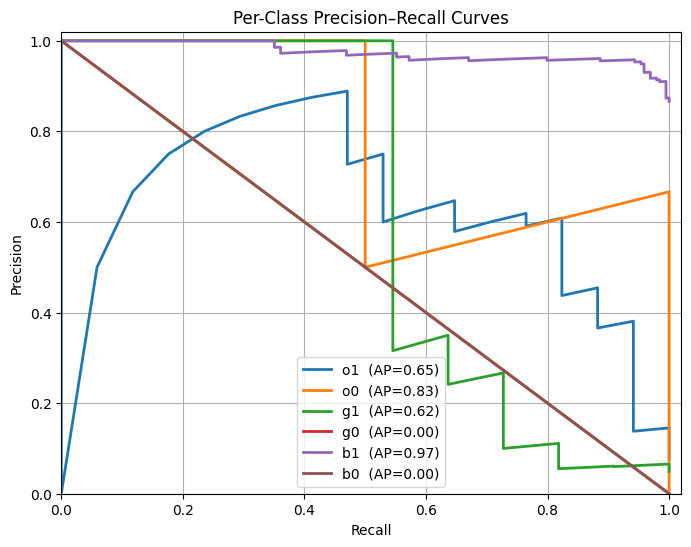

In [20]:
# ── Evaluation cell (loads best checkpoint, prints metrics & plots PR curves) ──
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score)
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1 ️⃣  load the best weights saved by early-stopping
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()

# 2 ️⃣  collect logits, preds, gts and soft-max probabilities
logits_all, gts_all = [], []
with torch.no_grad():
    for X, lengths, y in test_loader:      # assumes test_loader returns X, lengths, y
        X, lengths = X.to(device), lengths.to(device)
        logits = model(X, lengths)         # (B, 6)
        logits_all.append(logits.cpu())
        gts_all.append(y.cpu())

logits_all = torch.cat(logits_all)
gts_all    = torch.cat(gts_all)            # shape (N,)
probs_all  = F.softmax(logits_all, dim=1)  # shape (N, 6)
preds_all  = probs_all.argmax(1)

# 3 ️⃣  classification report
class_names = ["o1", "o0", "g1", "g0", "b1", "b0"]
print(classification_report(gts_all,
                            preds_all,
                            labels = list(range(6)),
                            target_names = class_names,
                            zero_division = 0))

# 4 ️⃣  pretty confusion-matrix
cm = confusion_matrix(gts_all, preds_all, labels=list(range(6)))
cm_df = pd.DataFrame(cm,
                     index  =[f"True:{n}"      for n in class_names],
                     columns=[f"Predicted:{n}" for n in class_names])
display(cm_df.style.background_gradient(axis=None, cmap="Blues"))

# 5 ️⃣  per-class Precision-Recall curves  ──────────────────────────────
plt.figure(figsize=(8, 6))

for c, cname in enumerate(class_names):
    y_true  = (gts_all.numpy() == c).astype(int)   # binary labels for this class
    y_score = probs_all[:, c].numpy()              # predicted prob for this class

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    plt.plot(recall, precision, lw=2,
             label=f"{cname}  (AP={ap:0.2f})")     # default colour cycle

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Per-Class Precision–Recall Curves")
plt.xlim(0, 1.02); plt.ylim(0, 1.02)
plt.legend()
plt.grid(True)
plt.show()


c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\USER\anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:

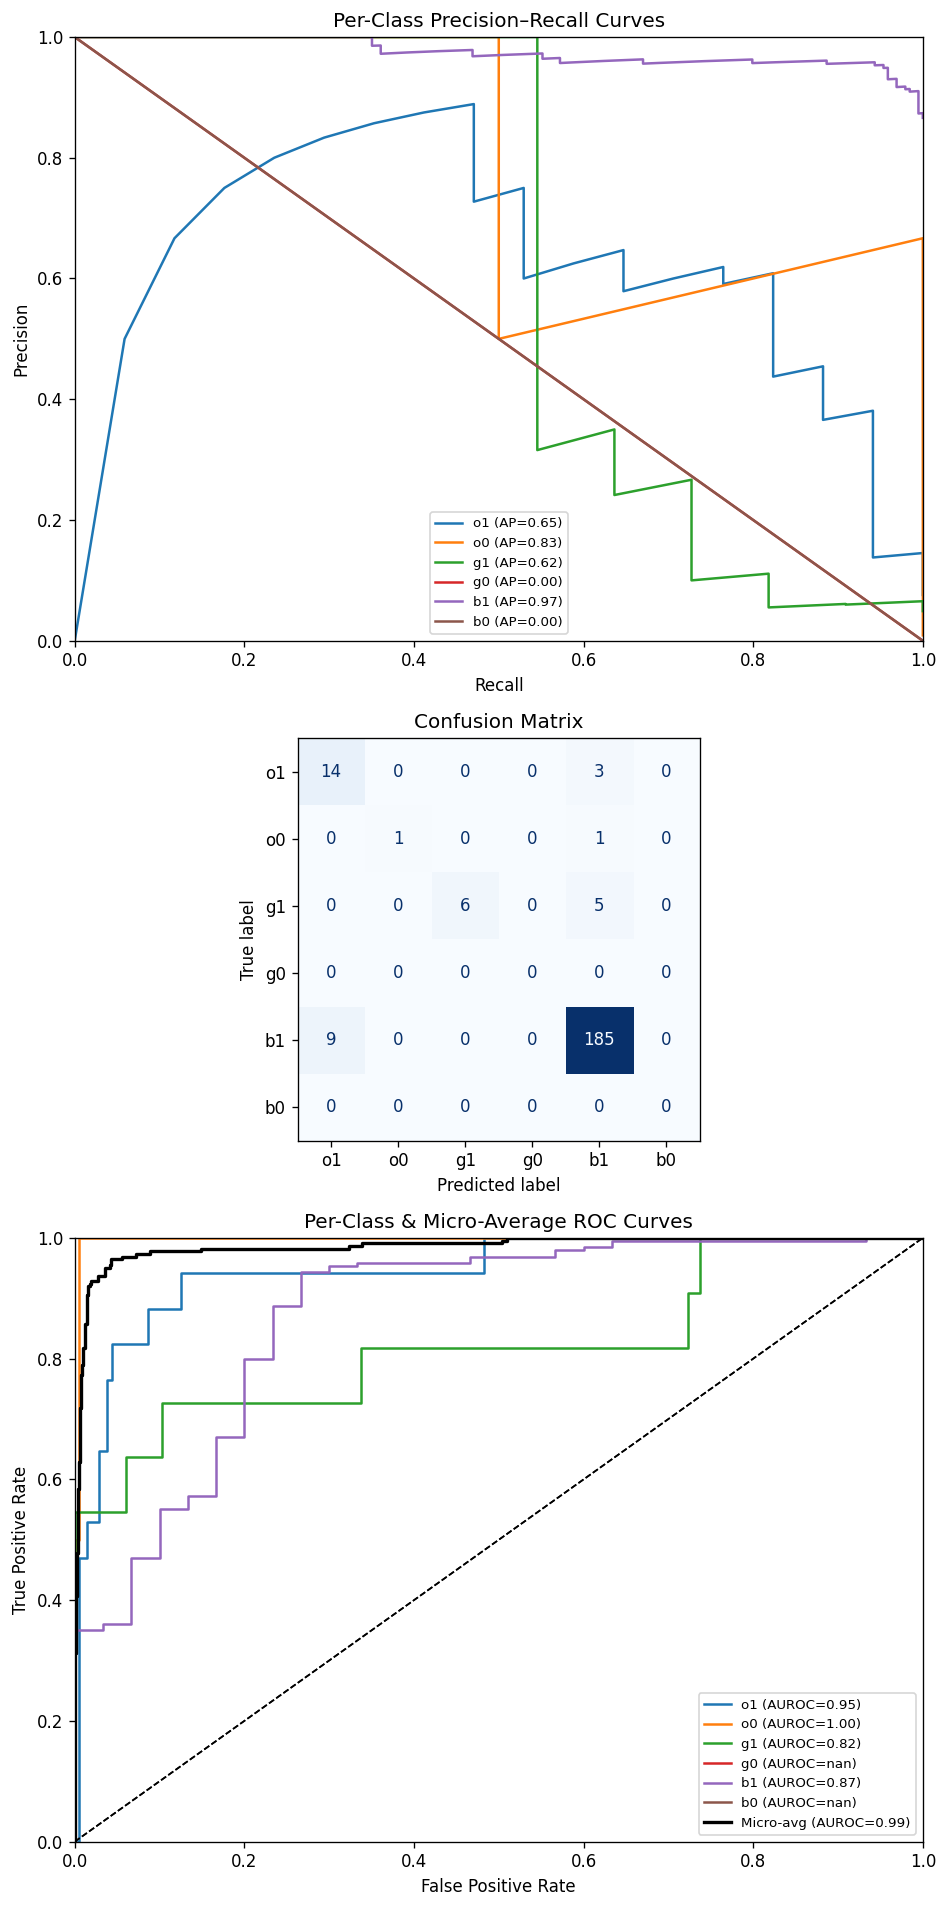

In [21]:
import numpy as np, matplotlib.pyplot as plt, torch
import torch.nn.functional as F
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay)

# ------------------------------------------------------------------
# 0.  Ensure tensors are on CPU / NumPy
# ------------------------------------------------------------------
y_prob = probs_all.numpy()                  # (N, 6)
y_true = gts_all.numpy()                    # (N,)
y_pred = y_prob.argmax(1)                   # (N,)

names = ["o1", "o0", "g1", "g0", "b1", "b0"]   # adjust if needed
n_classes = y_prob.shape[1]

# one-hot ground truth for sklearn helpers
Y_onehot = np.eye(n_classes)[y_true]

# ------------------------------------------------------------------
# 1.  Build PR & ROC data
# ------------------------------------------------------------------
curves, aps, rocs = {}, {}, {}
for k in range(n_classes):
    # PR
    p, r, _ = precision_recall_curve(Y_onehot[:, k], y_prob[:, k])
    curves[k] = (p, r)
    aps[k]    = average_precision_score(Y_onehot[:, k], y_prob[:, k])

    # ROC
    fpr, tpr, _ = roc_curve(Y_onehot[:, k], y_prob[:, k])
    rocs[k]     = (fpr, tpr, auc(fpr, tpr))

# ------------------------------------------------------------------
# 2.  Confusion matrix
# ------------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))

# ------------------------------------------------------------------
# 3.  Plot PR, Confusion Matrix, ROC
# ------------------------------------------------------------------
fig, (ax_pr, ax_cm, ax_roc) = plt.subplots(
        3, 1, figsize=(8, 16),
        gridspec_kw={'height_ratios': [3, 2, 3]}, dpi=120)

# — Precision-Recall curves —
for k, (p, r) in curves.items():
    ax_pr.plot(r, p, label=f"{names[k]} (AP={aps[k]:.2f})")
ax_pr.set_title("Per-Class Precision–Recall Curves")
ax_pr.set_xlabel("Recall");  ax_pr.set_ylabel("Precision")
ax_pr.set_xlim(0, 1); ax_pr.set_ylim(0, 1)
ax_pr.legend(fontsize=8)

# — Confusion matrix —
disp = ConfusionMatrixDisplay(cm, display_labels=names)
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title("Confusion Matrix")

# — ROC curves —
for k, (fpr, tpr, auc_) in rocs.items():
    ax_roc.plot(fpr, tpr, label=f"{names[k]} (AUROC={auc_:.2f})")
ax_roc.plot([0, 1], [0, 1], "k--", lw=1)
ax_roc.set_title("Per-Class ROC Curves")
ax_roc.set_xlabel("False Positive Rate"); ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_xlim(0, 1); ax_roc.set_ylim(0, 1)
ax_roc.legend(fontsize=8)


# —— NEW • Micro-average ROC -------------------------------------------------
fpr_micro, tpr_micro, _ = roc_curve(
    Y_onehot.ravel(),          # ▶ correct format
    y_prob.ravel()
)
auc_micro = auc(fpr_micro, tpr_micro)

ax_roc.plot(fpr_micro, tpr_micro, color="black", lw=2,
            label=f"Micro-avg (AUROC={auc_micro:.2f})")
# ---------------------------------------------------------------------------

ax_roc.plot([0, 1], [0, 1], "k--", lw=1)
ax_roc.set_title("Per-Class & Micro-Average ROC Curves")
ax_roc.set_xlabel("False Positive Rate"); ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_xlim(0, 1); ax_roc.set_ylim(0, 1)
ax_roc.legend(fontsize=8)

plt.tight_layout()
plt.show()

inspect label Distribution

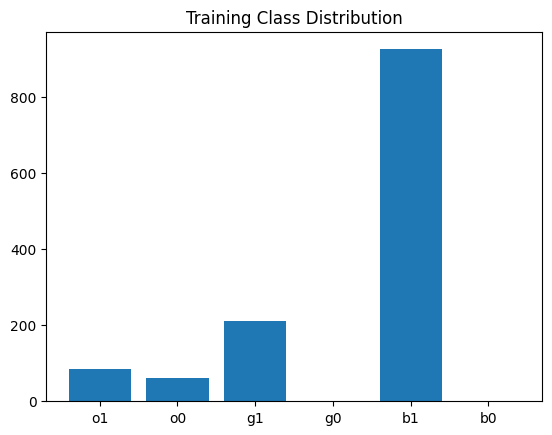

In [22]:
import collections
import matplotlib.pyplot as plt

label_names = ["o1", "o0", "g1", "g0", "b1", "b0"]
counts = collections.Counter(train_labels)
plt.bar(label_names, [counts[i] for i in range(6)])
plt.title("Training Class Distribution")
plt.show()


Save the model

In [23]:
(df_test_clean                      # ← already scaled/clean DataFrame
 .groupby("throw_uid")["class_id"]  # one row per physical throw
 .first()                           # each uid has a single class_id
 .value_counts())                   # how many throws per class


class_id
4    194
0     17
2     11
1      2
Name: count, dtype: int64

In [24]:
# torch.save({
#     "model_state": model.state_dict(),
#     "scaler_state": scaler,              # reuse at inference
#     "feature_cols": FEATURE_COLS
# }, "throw_lstm_v1.pt")

# print("Model saved → throw_lstm_v1.pt")


If need to pip install anything on my PC - GPU:

import sys, os, platform
print("Kernel executable :", sys.executable)
print("Python version    :", platform.python_version())


then:

"<path-from-sys.executable>" -m pip install --upgrade torchmetrics